_O@_melt
"Load data

This cell 
* loads the data
* rescales melting points and thermodynamic features in order to provide for better numerical stability.
* Filters outliers and drops duplicates

In [1]:
# Installation if not done before
# !pip install -r ../requirements.txt

In [51]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
%load_ext autoreload
%autoreload 2
import logging
import pickle
from collections import Counter

import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# from dominance_analysis import Dominance
from pymatgen.core import Composition as C
from tqdm import tqdm, trange
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

from s4.data import open_data
from s4.ml.wls import linear_model_analysis, feature_importance
from s4.ml.plotting import periodic_table_heatmap
from s4.ml.nonlinear import model_cv_analysis, custom_grid_search

plt.rcParams["font.size"] = "20"
plt.rcParams["font.family"] = "Helvetica"

logging.basicConfig(level=logging.INFO)

# Load ML data from the dump file from my runs.
with open('intermediate_data/DMM_TrainingData.pypickle', 'rb') as f:
    ml_data = pickle.load(f)
    
# Replace "." in feature names
ml_data = ml_data.rename(axis=1, mapper=lambda x: x.replace('3.15', '3_15'))

# We need to scale down melting points because they cause numerical instabilities in statsmodels
scale_down = [
    'feature_exp_min_mp',
    'feature_exp_max_mp',
    'feature_exp_mean_mp',
    'feature_exp_div_mp',
    'feature_thermo_lb_temp',
    'feature_thermo_ub_temp',
]
for feat in scale_down:
    ml_data[feat] = ml_data[feat] / 1000
    
scale_up = [
    'feature_thermo_total_ddf',
    'feature_thermo_first_ddf',
]
# # We need to scale up thermo quantities because they cause numerical instabilities in statsmodels
for feat in scale_up:
    ml_data[feat] = ml_data[feat] * 1000

# Exclude those compositions that are interpolated: they have some weird thermo implications
# ml_data = ml_data.query('feature_syn_n_target_mixture == 1')

# Only take the first reaction, no duplicates within the same recipe
ml_data = ml_data.drop_duplicates(subset=('meta_k', 'meta_i')).set_index(keys=['meta_k', 'meta_i'])

# Split the dataset and select carbonate/oxide and oxide/oxide reactions
carb_oxi = ml_data.query('feature_syn_n_carbonates>0').dropna()
oxi_oxi = ml_data.query('feature_syn_n_carbonates==0').dropna()

def simple_outlier_detection(pd, column):
    """Removes outliers outside of 2x IQR"""
    qt = numpy.quantile(pd[column].values, [0.05, 0.95])
    lb, ub = 2*qt[0] - qt[1], 2*qt[1] - qt[0]
    new_pd = pd.loc[pd[column].apply(lambda x: lb <= x <= ub)]
    if len(new_pd) < len(pd):
        #print('Dropped %d rows for column %s' % ((len(pd)-len(new_pd)), column))
        pass
    return new_pd

#print('==== Outlier detection for carbonate/oxide reactions ====')
for name in carb_oxi.columns:
    if not name.startswith('feature_') or carb_oxi[name].dtype.kind != 'f':
        continue
    carb_oxi = simple_outlier_detection(carb_oxi, name)
    
#print('==== Outlier detection for oxide/oxide reactions ====')
for name in oxi_oxi.columns:
    if not name.startswith('feature_') or oxi_oxi[name].dtype.kind != 'f':
        continue
    oxi_oxi = simple_outlier_detection(oxi_oxi, name)

# carb_oxi.to_csv('Carb.csv')
# oxi_oxi.to_csv('Oxi.csv')

print(f'Precursor type: carbonate + oxide, there are {len(carb_oxi)} entries')
print(f'Precursor type: oxide + oxide, there are {len(oxi_oxi)} entries')

Precursor type: carbonate + oxide, there are 3182 entries
Precursor type: oxide + oxide, there are 3143 entries


In [3]:
predictive_features = [
    'feature_ele_Li', 'feature_ele_Be', 'feature_ele_B', 'feature_ele_C', 'feature_ele_N', 'feature_ele_O',
    'feature_ele_F', 'feature_ele_Na', 'feature_ele_Mg', 'feature_ele_Al', 'feature_ele_Si', 'feature_ele_P',
    'feature_ele_S', 'feature_ele_Cl', 'feature_ele_K', 'feature_ele_Ca', 'feature_ele_Sc', 'feature_ele_Ti',
    'feature_ele_V', 'feature_ele_Cr', 'feature_ele_Mn', 'feature_ele_Fe', 'feature_ele_Co', 'feature_ele_Ni',
    'feature_ele_Cu', 'feature_ele_Zn', 'feature_ele_Ga', 'feature_ele_Ge', 'feature_ele_As', 'feature_ele_Se',
    'feature_ele_Br', 'feature_ele_Rb', 'feature_ele_Sr', 'feature_ele_Y', 'feature_ele_Zr', 'feature_ele_Nb',
    'feature_ele_Mo', 'feature_ele_Ru', 'feature_ele_Rh', 'feature_ele_Pd', 'feature_ele_Ag', 'feature_ele_Cd',
    'feature_ele_In', 'feature_ele_Sn', 'feature_ele_Sb', 'feature_ele_Te', 'feature_ele_Cs', 'feature_ele_Ba',
    'feature_ele_La', 'feature_ele_Ce', 'feature_ele_Pr', 'feature_ele_Nd', 'feature_ele_Sm', 'feature_ele_Eu',
    'feature_ele_Gd', 'feature_ele_Tb', 'feature_ele_Dy', 'feature_ele_Ho', 'feature_ele_Er', 'feature_ele_Tm',
    'feature_ele_Yb', 'feature_ele_Lu', 'feature_ele_Hf', 'feature_ele_Ta', 'feature_ele_W', 'feature_ele_Re',
    'feature_ele_Os', 'feature_ele_Ir', 'feature_ele_Hg', 'feature_ele_Tl', 'feature_ele_Pb', 'feature_ele_Bi',
    'feature_ele_Th', 'feature_ele_U', 

    'feature_text_is_ball_milling', 'feature_text_is_multi_heating', 'feature_text_is_regrinding',
    'feature_text_is_binder', 'feature_text_is_distilled', 'feature_text_is_zirconia',
    'feature_text_is_diameter', 'feature_text_is_sintered', 'feature_text_is_wet', 'feature_text_is_PVA',
    'feature_text_is_polycrystal', 'feature_text_is_phosphors', 'feature_text_is_homoge',
    'feature_text_is_ground', 'feature_text_is_again',

#     'feature_thermo_lb_temp', 'feature_thermo_ub_temp',

    'feature_thermo_1073_15_total_df', 'feature_thermo_1073_15_first_df', 'feature_thermo_1073_15_last_df',
    'feature_thermo_1073_15_first_df_frac', 'feature_thermo_1073_15_last_df_frac',

    'feature_thermo_1173_15_total_df', 'feature_thermo_1173_15_first_df', 'feature_thermo_1173_15_last_df',
    'feature_thermo_1173_15_first_df_frac', 'feature_thermo_1173_15_last_df_frac',

    'feature_thermo_1273_15_total_df', 'feature_thermo_1273_15_first_df', 'feature_thermo_1273_15_last_df',
    'feature_thermo_1273_15_first_df_frac', 'feature_thermo_1273_15_last_df_frac',

    'feature_thermo_1373_15_total_df', 'feature_thermo_1373_15_first_df', 'feature_thermo_1373_15_last_df',
    'feature_thermo_1373_15_first_df_frac', 'feature_thermo_1373_15_last_df_frac',

    'feature_thermo_1473_15_total_df', 'feature_thermo_1473_15_first_df', 'feature_thermo_1473_15_last_df',
    'feature_thermo_1473_15_first_df_frac', 'feature_thermo_1473_15_last_df_frac',

    'feature_thermo_1573_15_total_df', 'feature_thermo_1573_15_first_df', 'feature_thermo_1573_15_last_df',
    'feature_thermo_1573_15_first_df_frac', 'feature_thermo_1573_15_last_df_frac', 

    'feature_thermo_total_ddf', 'feature_thermo_first_ddf', 

    'feature_exp_min_mp', 'feature_exp_max_mp', 'feature_exp_mean_mp', 'feature_exp_div_mp',
    'feature_avg_p_h_300K', 'feature_min_p_h_300K', 'feature_max_p_h_300K', 'feature_diff_p_h_300K',
    'feature_avg_dgf_300K', 'feature_min_dgf_300K', 'feature_max_dgf_300K', 'feature_diff_dgf_300K',
]

predictive_features_elemental = [
    'feature_ele_Li', 'feature_ele_Be', 'feature_ele_B', 'feature_ele_C', 'feature_ele_N', 'feature_ele_O',
    'feature_ele_F', 'feature_ele_Na', 'feature_ele_Mg', 'feature_ele_Al', 'feature_ele_Si', 'feature_ele_P',
    'feature_ele_S', 'feature_ele_Cl', 'feature_ele_K', 'feature_ele_Ca', 'feature_ele_Sc', 'feature_ele_Ti',
    'feature_ele_V', 'feature_ele_Cr', 'feature_ele_Mn', 'feature_ele_Fe', 'feature_ele_Co', 'feature_ele_Ni',
    'feature_ele_Cu', 'feature_ele_Zn', 'feature_ele_Ga', 'feature_ele_Ge', 'feature_ele_As', 'feature_ele_Se',
    'feature_ele_Br', 'feature_ele_Rb', 'feature_ele_Sr', 'feature_ele_Y', 'feature_ele_Zr', 'feature_ele_Nb',
    'feature_ele_Mo', 'feature_ele_Ru', 'feature_ele_Rh', 'feature_ele_Pd', 'feature_ele_Ag', 'feature_ele_Cd',
    'feature_ele_In', 'feature_ele_Sn', 'feature_ele_Sb', 'feature_ele_Te', 'feature_ele_Cs', 'feature_ele_Ba',
    'feature_ele_La', 'feature_ele_Ce', 'feature_ele_Pr', 'feature_ele_Nd', 'feature_ele_Sm', 'feature_ele_Eu',
    'feature_ele_Gd', 'feature_ele_Tb', 'feature_ele_Dy', 'feature_ele_Ho', 'feature_ele_Er', 'feature_ele_Tm',
    'feature_ele_Yb', 'feature_ele_Lu', 'feature_ele_Hf', 'feature_ele_Ta', 'feature_ele_W', 'feature_ele_Re',
    'feature_ele_Os', 'feature_ele_Ir', 'feature_ele_Hg', 'feature_ele_Tl', 'feature_ele_Pb', 'feature_ele_Bi',
    'feature_ele_Th', 'feature_ele_U', 

    'feature_text_is_ball_milling', 'feature_text_is_multi_heating', 'feature_text_is_regrinding',
    'feature_text_is_binder', 'feature_text_is_distilled', 'feature_text_is_zirconia',
    'feature_text_is_diameter', 'feature_text_is_sintered', 'feature_text_is_wet', 'feature_text_is_PVA',
    'feature_text_is_polycrystal', 'feature_text_is_phosphors', 'feature_text_is_homoge',
    'feature_text_is_ground', 'feature_text_is_again',
]

## Main results

### (Sec. Results.1) Dominance importance

#### Compute dominance levels

In [4]:
print('Compute DI values for carbonate/oxide reactions, prediction target temperature.')
use_cached = True

if use_cached:
    co_importance = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_CO.csv').set_index('Unnamed: 0')
    oo_importance = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_OO.csv').set_index('Unnamed: 0')
else:
    co_importance = feature_importance(
        data_frame=carb_oxi[predictive_features + ['y_temperature']], 
        features=predictive_features,
        y_name='y_temperature', 
        do_wls=True, weights=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
        processes=4, submodel_search=400)
    oo_importance = feature_importance(
        data_frame=oxi_oxi[predictive_features + ['y_temperature']], 
        features=predictive_features,
        y_name='y_temperature', 
        do_wls=True, weights=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
        processes=4, submodel_search=400)

Compute DI values for carbonate/oxide reactions, prediction target temperature.


#### Make plots (Fig. 2)

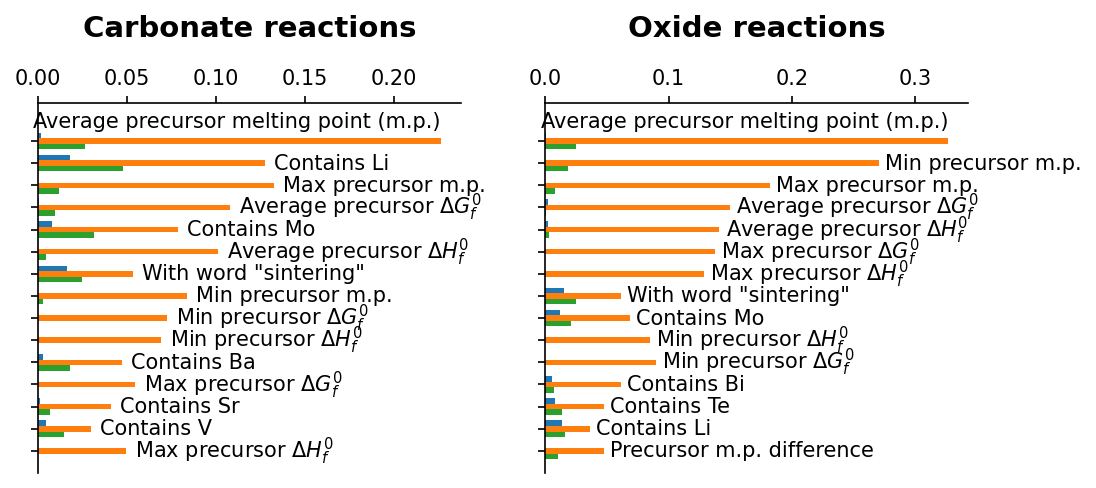

In [5]:
feature_names = {
    'feature_exp_mean_mp': "Average precursor melting point (m.p.)",
    'feature_exp_min_mp': "Min precursor m.p.",
    'feature_exp_max_mp': "Max precursor m.p.",
    'feature_exp_div_mp': "Precursor m.p. difference",
    'feature_min_dgf_300K': "Min precursor $\Delta G_f^0$",
    'feature_avg_dgf_300K': "Average precursor $\Delta G_f^0$",
    'feature_max_dgf_300K': "Max precursor $\Delta G_f^0$",
    'feature_min_p_h_300K': "Min precursor $\Delta H_f^0$",
    'feature_avg_p_h_300K': "Average precursor $\Delta H_f^0$",
    'feature_max_p_h_300K': "Max precursor $\Delta H_f^0$",
    'feature_ele_Li': 'Contains Li',
    'feature_ele_Na': 'Contains Na',
    'feature_ele_Ba': 'Contains Ba',
    'feature_ele_Te': 'Contains Te',
    'feature_ele_Mo': 'Contains Mo',
    'feature_ele_Bi': 'Contains Bi',
    'feature_ele_K': 'Contains K',
    'feature_ele_P': 'Contains P',
    'feature_ele_O': 'Contains O',
    'feature_ele_Y': 'Contains Y',
    'feature_ele_Ce': 'Contains Ce',
    'feature_ele_Sr': 'Contains Sr',
    'feature_ele_Nd': 'Contains Nd',
    'feature_ele_Si': 'Contains Si',
    'feature_ele_Zr': 'Contains Zr',
    'feature_ele_Mn': 'Contains Mn',
    'feature_ele_Ti': 'Contains Ti',
    'feature_ele_Te': 'Contains Te',
    'feature_ele_La': 'Contains La',
    'feature_ele_Cd': 'Contains Cd',
    'feature_ele_Hf': 'Contains Hf',
    'feature_ele_Rb': 'Contains Rb',
    'feature_ele_Ru': 'Contains Ru',
    'feature_ele_Th': 'Contains Th',
    'feature_ele_In': 'Contains In',
    'feature_ele_Ga': 'Contains Ga',
    'feature_ele_Pb': 'Contains Pb',
    'feature_ele_Fe': 'Contains Fe',
    'feature_ele_V': 'Contains V',
    'feature_text_is_sintered': 'With word "sintering"',
    'feature_text_is_polycrystal': 'With word "polycrystal"',
    'feature_text_is_binder': 'With word "binder"',
    'feature_text_is_PVA': 'With word "PVA"',
    'feature_text_is_distilled': 'With word "distilled"',
    'feature_text_is_diameter': 'With word "diameter"',
    'feature_text_is_phosphors': 'With word "Phosphors"',
    'feature_text_is_ball_milling': 'With word "ball-milling"',
    'feature_text_is_wet': 'With word "wet"',
    'feature_text_is_multi_heating': 'With multiple words "heating"',
    'feature_text_is_ground': 'With word "grinding"',
    'feature_text_is_regrinding': 'With word "regrinding"',
    'feature_thermo_1k_total_ddf': 'Derivative of total driving force @ 1k °C',
    'feature_thermo_1k_first_df': 'First pairwise reaction driving force @ 1k °C',
    'feature_thermo_1k_first_ddf': 'Derivative of first driving force @ 1k °C',
}

fig = plt.figure(figsize=(8, 3.2), dpi=150)
ax1 = fig.add_axes(121)
ax2 = fig.add_axes(122)

def plot_to_ax(di_stats, ax, pad=0.005):
    nlevels = len(di_stats)
    ax.barh(
        numpy.arange(nlevels)-0.25,
        di_stats['Interactional Dominance'],
        height=0.25,
        align='center',
        label='Interactional (IADI)')
    ax.barh(
        numpy.arange(nlevels),
        di_stats['Individual Dominance'],
        height=0.25,
        align='center',
        label='Individual (IDI)')
    ax.barh(
        numpy.arange(nlevels)+0.25,
        di_stats['Estimated Average Partial Dominance'],
        height=0.25,
        align='center',
        label='Average Partial (APDI)')
    ax.set_yticks(numpy.arange(nlevels))
    ax.set_yticklabels(['']*nlevels, fontsize=10)
    ax.invert_yaxis()
#     ax.set_xlabel('Dominance Importance', fontsize=10)

    max_dominance = di_stats[[
        'Interactional Dominance', 'Individual Dominance', 'Estimated Average Partial Dominance']].max(axis=1)
    ax.text(
        max_dominance.values[0], -0.9,
        feature_names.get(max_dominance.index[0], max_dominance.index[0]),
        ha='right', va='center', fontsize=10)
    for i in range(1, nlevels):
        ax.text(
            max_dominance.values[i] + pad, i,
            feature_names.get(max_dominance.index[i], max_dominance.index[i]),
            ha='left', va='center', fontsize=10)

plot_to_ax(co_importance.iloc[:15].clip(lower=0.0), ax1, pad=0.005)
plot_to_ax(oo_importance.iloc[:15].clip(lower=0.0), ax2, pad=0.005)
ax1.xaxis.tick_top()
ax1.tick_params(axis='both', labelsize=10)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim([15, -1.7])
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Carbonate reactions', fontweight='bold', labelpad=15.5, fontsize=14)
ax2.xaxis.tick_top()
ax2.tick_params(axis='both', labelsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylim([15, -1.7])
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Oxide reactions', fontweight='bold', labelpad=15.5, fontsize=14)
plt.show()

### (Sec Results.2) Building full model with forward selection

In this section we begin to build models using WLS. The full notebook also has an example using LARS for regression, but we'll focus on the WLS example here.

#### Temperature & Time models

In [6]:
from s4.ml.wls import forward_selection_by_bic

temp_co_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_CO.csv').set_index('Unnamed: 0')
temp_oo_di = pandas.read_csv('intermediate_data/Dominance_Importance_Temp_OO.csv').set_index('Unnamed: 0')

print('====== Start BIC forward selection for carbonate/oxide reactions ======')
temp_co_feature_path, temp_co_fit_result = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=co_importance.index.values,
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_co_feature_path)
print(temp_co_fit_result.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
temp_oo_feature_path, temp_oo_fit_result = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=oo_importance.index.values,
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_oo_feature_path)
print(temp_oo_fit_result.summary())

====== Start BIC forward selection for carbonate/oxide reactions ======
Feature path ['feature_exp_mean_mp', 'feature_ele_Li', 'feature_avg_dgf_300K', 'feature_ele_Mo', 'feature_avg_p_h_300K', 'feature_text_is_sintered', 'feature_ele_Ba', 'feature_ele_Sr', 'feature_ele_V', 'feature_ele_Na', 'feature_thermo_first_ddf', 'feature_ele_Bi', 'feature_thermo_total_ddf', 'feature_ele_Al', 'feature_ele_Rb', 'feature_ele_Si', 'feature_ele_W', 'feature_ele_N', 'feature_ele_Ga', 'feature_ele_Ce', 'feature_ele_Te', 'feature_ele_Sn', 'feature_text_is_ball_milling', 'feature_ele_Br', 'feature_ele_Nb', 'feature_ele_K', 'feature_ele_Yb', 'feature_ele_Cs', 'feature_ele_Tl', 'feature_ele_Hf', 'feature_ele_S', 'feature_ele_Er', 'feature_diff_p_h_300K', 'feature_ele_Ni', 'feature_ele_Ru', 'feature_ele_Ho', 'feature_ele_C', 'feature_ele_Dy']
                            WLS Regression Results                            
Dep. Variable:          y_temperature   R-squared:                       0.555
Model:    

#### Elemental effects (temperature & time) models

In this section we choose only elemental features to determine the effect of inclusion of certain elements.

In [7]:
from s4.ml.wls import forward_selection_by_bic

print('====== Start BIC forward selection for carbonate/oxide reactions ======')
temp_co_feature_path_elemental, temp_co_fit_result_elemental = forward_selection_by_bic(
    data_frame=carb_oxi, 
    features_sorted=[x for x in temp_co_di.index.values if x in predictive_features_elemental],
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_co_feature_path_elemental)
print(temp_co_fit_result_elemental.summary())

print('====== Start BIC forward selection for oxide/oxide reactions ======')
temp_oo_feature_path_elemental, temp_oo_fit_result_elemental = forward_selection_by_bic(
    data_frame=oxi_oxi, 
    features_sorted=[x for x in temp_oo_di.index.values if x in predictive_features_elemental],
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2
)
print('Feature path', temp_oo_feature_path_elemental)
print(temp_oo_fit_result_elemental.summary())

====== Start BIC forward selection for carbonate/oxide reactions ======
Feature path ['feature_ele_Li', 'feature_ele_Mo', 'feature_text_is_sintered', 'feature_ele_Ba', 'feature_ele_Sr', 'feature_ele_V', 'feature_ele_Na', 'feature_ele_Bi', 'feature_ele_Al', 'feature_ele_Rb', 'feature_ele_Si', 'feature_ele_W', 'feature_ele_N', 'feature_ele_Ga', 'feature_ele_Ce', 'feature_ele_Te', 'feature_ele_Ta', 'feature_ele_Sn', 'feature_text_is_ball_milling', 'feature_ele_Ca', 'feature_ele_Br', 'feature_ele_Nb', 'feature_ele_Y', 'feature_ele_K', 'feature_ele_Yb', 'feature_ele_Ag', 'feature_ele_Cs', 'feature_ele_Tl', 'feature_ele_Hf', 'feature_ele_S', 'feature_ele_Sc', 'feature_ele_Zr', 'feature_ele_Er', 'feature_ele_Co', 'feature_ele_Sm', 'feature_ele_Ti', 'feature_text_is_PVA', 'feature_ele_Sb', 'feature_ele_La', 'feature_ele_Pb', 'feature_text_is_diameter', 'feature_ele_Pd', 'feature_ele_Cl', 'feature_ele_Lu', 'feature_ele_Eu']
                            WLS Regression Results                     

#### Make plots (Fig. 3)

Here we demonstrate the performance of the model on a scatter plot.

/tmp/ipykernel_144715/214810045.py:42: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax1_sc.legend(**legend_format).legendHandles:


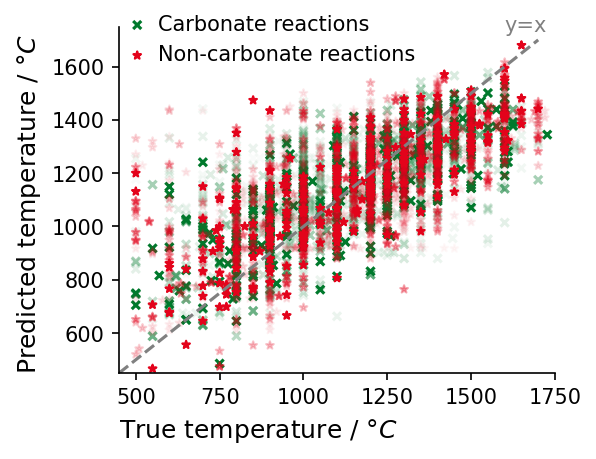

In [8]:
from s4.ml.plotting import periodic_table_heatmap_sbs
from matplotlib.colors import to_rgb
from s4.ml.plotting import generate_pt_triangulation

fig = plt.figure(figsize=(3.75, 3), dpi=150)

################################################################
################################################################
# Plot scatter plots
################################################################
################################################################

ax1_sc = fig.add_subplot(111)

def plot_scatters(fit_result, weights, ax, marker, base_color, plot_label):
    alphas = weights / weights.max()
    r, g, b = to_rgb(base_color)
    color = [(r, g, b, alpha) for alpha in alphas]
    observed = fit_result.resid + fit_result.fittedvalues
    fitted = fit_result.fittedvalues
    ax.scatter(observed, fitted, marker=marker, s=15, color=color, label=plot_label)

colors = [
    '#00792c',
    '#e3031b',
    '#054561',
    '#e20619'
]
plot_scatters(
    fit_result=temp_co_fit_result, 
    weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax1_sc, marker='x', base_color=colors[0], plot_label='Carbonate reactions')
plot_scatters(
    fit_result=temp_oo_fit_result, 
    weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
    ax=ax1_sc, marker='*', base_color=colors[1], plot_label='Non-carbonate reactions')

legend_format = {
    'fontsize': 10, 'fancybox': False, 'frameon': False, 
    'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left',
    'bbox_to_anchor': (-0.03, 1.065)}
for lh in ax1_sc.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)

ax1_sc.spines['right'].set_visible(False)
ax1_sc.spines['top'].set_visible(False)

# Diagonal line
ax1_sc.plot([450, 1700], [450, 1700], color='gray', linestyle='--')
ax1_sc.text(1600, 1730, 'y=x', fontsize=10, color='gray')

# Scatter plots
ax1_sc.set_xlabel('True temperature / $°C$', fontsize=12, loc='left')
ax1_sc.set_ylabel("Predicted temperature / $°C$", fontsize=12, loc='bottom')
ax1_sc.tick_params(axis='both', which='major', labelsize=10)
ax1_sc.set_ylim([450, 1750])
ax1_sc.set_xlim([450, 1750])
#ax1_sc.set_xticks([600, 800, 1000])

# plt.tight_layout()\
plt.show()

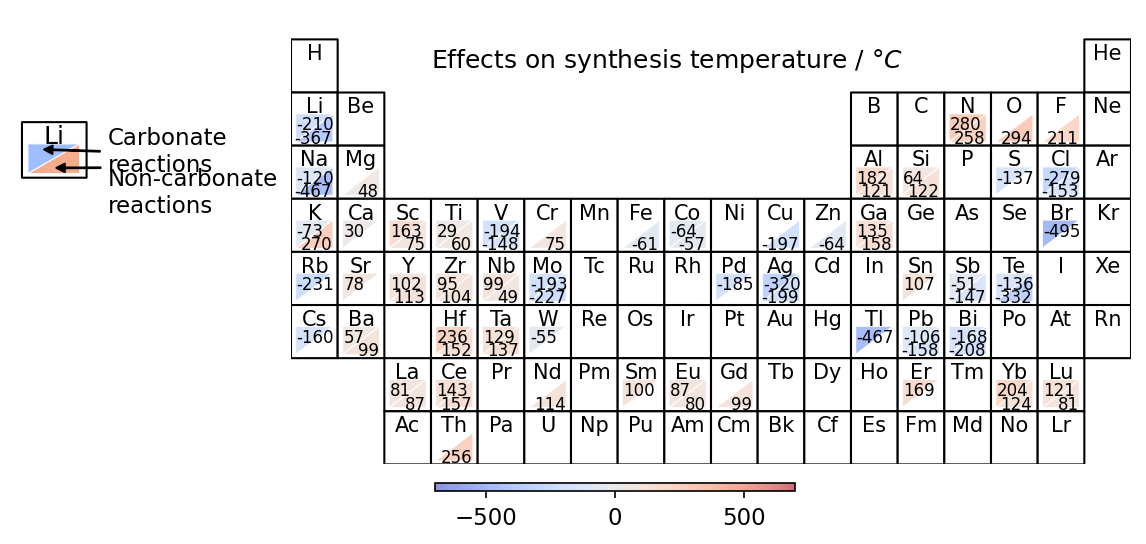

In [9]:
from s4.ml.plotting import periodic_table_heatmap_sbs
from matplotlib.colors import to_rgb
from s4.ml.plotting import generate_pt_triangulation
from matplotlib.colors import ListedColormap

my_cmap = plt.cm.coolwarm(numpy.arange(plt.cm.coolwarm.N))
my_cmap[:,0:3] = 1 - (1-my_cmap[:,0:3])*0.6
my_cmap = ListedColormap(my_cmap)

def draw_example(ax):
    tri_x, tri_y, tri_upper, tri_lower = generate_pt_triangulation(1, {1: 0})
    ax.pcolor(
        numpy.arange(2),
        numpy.arange(2) * 1.5,
        numpy.zeros((1, 1)),
        cmap='binary',
        # alpha=0.0,
        edgecolors="k",
        linewidths=1.,
        vmin=0,
        vmax=1,
    )
    heatmap = ax.tripcolor(
        tri_x, -tri_y, tri_upper[:1] + tri_lower[:1],
        [0.3, 0.7],
        cmap='coolwarm',
        edgecolors="white",
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )
    ax.text(
        0.5,
        0.4,
        'Li',
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=12,
        color='k',
    )
    ax.set_xlim([-0.1, 2.5])
    ax.set_ylim([-0.1, 1.6])
    ax.axis("off")
    ax.invert_yaxis()
    
    ax.annotate('Carbonate\nreactions', 
                xy=(0.3, 0.75),  xycoords='data',
                xytext=(0.55, 0.86), textcoords='axes fraction', fontsize=11,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )
    ax.annotate('Non-carbonate\nreactions', 
                xy=(0.5, 1.25),  xycoords='data',
                xytext=(0.55, 0.21), textcoords='axes fraction', fontsize=11,
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=4),
                ha='left', verticalalignment='top',
    )

plt.rcParams["font.family"] = "Helvetica"

fig = plt.figure(figsize=(8, 3), dpi=150)

ax1_pt = fig.add_axes([0.28, 0.12, 0.70, 1.0])

ax1_cbar = fig.add_axes([0.40, 0.06, 0.30, 0.018])

periodic_table_heatmap_sbs(
    {x.split('[')[0].split('_')[-1]: y
     for x, y in temp_co_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    {x.split('[')[0].split('_')[-1]: y
     for x, y in temp_oo_fit_result_elemental.params.items() 
     if x.startswith('feature_ele')},
    cmap=my_cmap,
    cax=ax1_cbar,
    cbar_label_size=11,
    value_format='\n%.0f',
    include_rows={1,2,3,4,5,6,8,9},
    ax=ax1_pt,
    pt_label_fontsize=10,
    pt_value_fontsize=8,
    cmap_range=(-700, 700),
)
ax1_pt.text(3, 0.8, 'Effects on synthesis temperature / $°C$', fontsize=12)

ax_legend = fig.add_axes([0.05, 0.75, 0.14, 0.14])
draw_example(ax_legend)

# plt.tight_layout()
plt.show()

### (Sec Results.3): Non-linear models

In this section we compare the performance of linear and non-linear models, specifically xgboost.

#### Linear model feature learning curve

In [10]:
use_cached = True

if use_cached:
    cv_linear_temp_co = pandas.read_csv('intermediate_data/LOOCV_Linear_Temp_CO.csv')
    cv_linear_temp_oo = pandas.read_csv('intermediate_data/LOOCV_Linear_Temp_OO.csv')
else:
    temp_co_linear_train_scores, temp_co_linear_cv_scores = [], []
    for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
        result = model_cv_analysis(
            data_frame=carb_oxi,
            features=temp_co_feature_path[:i],
            y_name='y_temperature', y_desc='Temperature',
            estimator=LinearRegression(),
            cv_method='loo',
            weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
            do_plot=False,
            display_pbar=False,
            processes=4,
        )
        temp_co_linear_train_scores.append(result['Train score'])
        temp_co_linear_cv_scores.append(result['CV score'])
        
    temp_oo_linear_train_scores, temp_oo_linear_cv_scores = [], []
    for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
        result = model_cv_analysis(
            data_frame=oxi_oxi,
            features=temp_oo_feature_path[:i],
            y_name='y_temperature', y_desc='Temperature',
            estimator=LinearRegression(),
            cv_method='loo',
            weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
            do_plot=False,
            display_pbar=False,
            processes=4,
        )
        temp_oo_linear_train_scores.append(result['Train score'])
        temp_oo_linear_cv_scores.append(result['CV score'])
    
    pandas.DataFrame({
        'Train': temp_co_linear_train_scores,
        'Valid': temp_co_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Temp_CO.csv')
    
    pandas.DataFrame({
        'Train': temp_oo_linear_train_scores,
        'Valid': temp_oo_linear_cv_scores}).to_csv('intermediate_data/LOOCV_Linear_Temp_OO.csv')

#### Build XGBoost tree models

The example includes some hyperparameter tuning that we'll skip for time.

In [11]:
use_cached = True

if use_cached:
    cv_xgboost_temp_co = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Temp_CO.csv')
    cv_xgboost_temp_oo = pandas.read_csv('intermediate_data/LOOCV_XGBoost_Temp_OO.csv')
else:
    # This is the code for xgboost training
    temp_co_xgboost_train, temp_co_xgboost_cv_scores = [], []
    for i in trange(1, len(temp_co_feature_path), desc='CO/Temperature'):
        result = model_cv_analysis(
            data_frame=carb_oxi,
            features=temp_co_feature_path[:i],
            y_name='y_temperature', y_desc='Temperature',
            estimator=XGBRegressor(
                n_estimators=300, max_depth=3, learning_rate=0.1, booster='gbtree', n_jobs=1, verbosity=0),
            cv_method='loo',
            weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
            do_plot=False,
            display_pbar=False,
            processes=16,
        )
        temp_co_xgboost_train.append(result['Train score'])
        temp_co_xgboost_cv_scores.append(result['CV score'])
        
    temp_oo_xgboost_train, temp_oo_xgboost_cv_scores = [], []
    for i in trange(1, len(temp_oo_feature_path), desc='OO/Temperature'):
        result = model_cv_analysis(
            data_frame=oxi_oxi,
            features=temp_oo_feature_path[:i],
            y_name='y_temperature', y_desc='Temperature',
            estimator=XGBRegressor(
                n_estimators=100, max_depth=5, learning_rate=0.2, booster='gbtree', n_jobs=1, verbosity=0),
            cv_method='loo',
            weights=1.0 / (1 + numpy.log(oxi_oxi['meta_precursor_freq'].values)) ** 2,
            do_plot=False,
            display_pbar=False,
            processes=16,
        )
        temp_oo_xgboost_train.append(result['Train score'])
        temp_oo_xgboost_cv_scores.append(result['CV score'])
    pandas.DataFrame({
        'Train': temp_co_xgboost_train,
        'Valid': temp_co_xgboost_cv_scores}).to_csv('intermediate_data/LOOCV_XGBoost_Temp_CO.csv')
    
    pandas.DataFrame({
        'Train': temp_oo_xgboost_train,
        'Valid': temp_oo_xgboost_cv_scores}).to_csv('intermediate_data/LOOCV_XGBoost_Temp_OO.csv')
    

#### Make plots (Fig. 4)

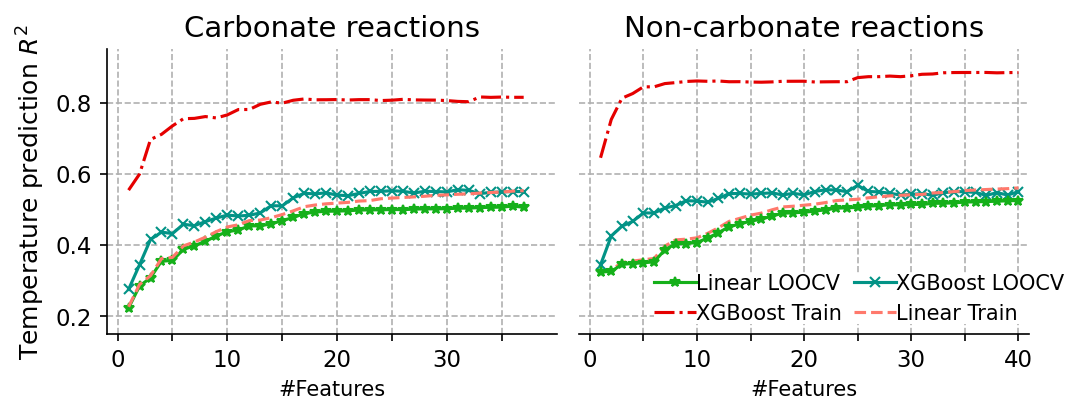

In [12]:
fig = plt.figure(figsize=(7.5, 5), dpi=150)
legend_format = {'fontsize': 10, 'fancybox': False, 'frameon': True, 'ncol': 2,
                 'facecolor': 'white', 'edgecolor': 'none', 'framealpha': 1.0,
                 'columnspacing': 0.6, 'bbox_to_anchor': [1.1, 0.0],
                 'borderpad': 0., 'handletextpad': 0., 'loc': 'lower right'}

ax1 = fig.add_axes([0.1, 0.54, 0.40, 0.38])
ax2 = fig.add_axes([0.52, 0.54, 0.40, 0.38])

ax1.plot(list(range(1, len(cv_linear_temp_co)+1)), cv_linear_temp_co['Train'], zorder=100, color='xkcd:salmon', linestyle='--', label='Linear Train')
ax1.plot(list(range(1, len(cv_linear_temp_co)+1)), cv_linear_temp_co['Valid'], '*-', color='xkcd:green', markersize=5,  label='Linear LOOCV')
ax1.plot(list(range(1, len(cv_xgboost_temp_co)+1)), cv_xgboost_temp_co['Train'], linestyle='dashdot', color='xkcd:red', label='XGBoost Train')
ax1.plot(list(range(1, len(cv_xgboost_temp_co)+1)), cv_xgboost_temp_co['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')
ax1.set_xlabel('#Features', fontsize=10)
ax1.set_ylabel('Temperature prediction $R^2$', fontsize=12)
# ax1.legend(**legend_format)
ax1.set_xticks(list(range(0, 40, 5)))
ax1.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 40, 5)], fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.grid('on', linestyle='--')
ax1.set_title('Carbonate reactions', fontsize=14)
ax1.set_xlim([-1, 40])
ax1.set_ylim([0.15, 0.95])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(list(range(1, len(cv_linear_temp_oo)+1)), cv_linear_temp_oo['Valid'], '*-', zorder=100, color='xkcd:green', markersize=5, label='Linear LOOCV')
ax2.plot(list(range(1, len(cv_xgboost_temp_oo)+1)), cv_xgboost_temp_oo['Train'], linestyle='dashdot', color='xkcd:red', label='XGBoost Train')
ax2.plot(list(range(1, len(cv_xgboost_temp_oo)+1)), cv_xgboost_temp_oo['Valid'], 'x-', color='xkcd:teal', markersize=5, label='XGBoost LOOCV')
ax2.plot(list(range(1, len(cv_linear_temp_oo)+1)), cv_linear_temp_oo['Train'], color='xkcd:salmon', linestyle='--', label='Linear Train')
ax2.set_xlabel('#Features', fontsize=10)
# ax2.set_ylabel('Temperature prediction R2', fontsize=10)
ax2.legend(**legend_format)
ax2.set_xticks(list(range(0, 41, 5)))
ax2.set_xticklabels([x if x % 10 == 0 else '' for x in range(0, 41, 5)], fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='y', which='both',length=0)
ax2.grid('on', linestyle='--')
ax2.set_yticklabels([])
ax2.set_title('Non-carbonate reactions', fontsize=14)
ax2.set_xlim([-1, 41])
ax2.set_ylim([0.15, 0.95])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.show()

## Manuscript discussion

### (Sec. Discussion.1) Temperature: Tamman's rule (Fig. D1)

In [13]:
tamman_co_result = sm.wls(
    formula=f"y_temperature ~ feature_exp_mean_mp", data=carb_oxi,
    weights=1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2,
).fit()

# tamman_co_result = sm.ols(
#     formula=f"y_temperature ~ feature_exp_mean_mp", data=carb_oxi,
# ).fit()

tamman_oo_result = sm.wls(
    formula=f"y_temperature ~ feature_exp_mean_mp", data=oxi_oxi,
    weights=1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2,
).fit()

# tamman_oo_result = sm.ols(
#     formula=f"y_temperature ~ feature_exp_mean_mp", data=oxi_oxi,
# ).fit()

print('Carbonate/oxide reactions result: Tamman\'s rule')
print(tamman_co_result.summary())
print('Oxide/oxide reactions result: Tamman\'s rule')
print(tamman_oo_result.summary())

print('SS table')
print('Carbonate/oxide RSS:', f'{tamman_co_result.ssr:.2g}')
print('Carbonate/oxide TSS:', f'{tamman_co_result.centered_tss:.2g}')
print('Oxide/oxide RSS:', f'{tamman_oo_result.ssr:.2g}')
print('Oxide/oxide TSS:', f'{tamman_oo_result.centered_tss:.2g}')

Carbonate/oxide reactions result: Tamman's rule
                            WLS Regression Results                            
Dep. Variable:          y_temperature   R-squared:                       0.227
Model:                            WLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     931.7
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          1.08e-179
Time:                        16:33:17   Log-Likelihood:                -22788.
No. Observations:                3182   AIC:                         4.558e+04
Df Residuals:                    3180   BIC:                         4.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/tmp/ipykernel_144715/1919673305.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax1.legend(**legend_format).legendHandles:


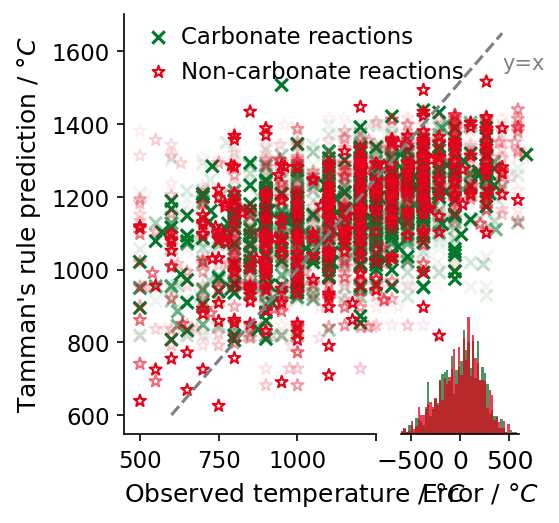

In [14]:
from s4.ml.utils import weights2colors

fig = plt.figure(figsize=(3.5, 3.5), dpi=150)

ax1 = fig.add_axes([0.20, 0.15, 0.78, 0.80])
ax2 = fig.add_axes([0.69, 0.15, 0.3, 0.3])

ax1.plot([600, 1650], [600, 1650], color='gray', linestyle='--')
ax1.text(1650, 1550, 'y=x', fontsize=10, color='gray')

# Carbonate/oxide
ax1.scatter(
    x=tamman_co_result.resid + tamman_co_result.fittedvalues, 
    y=tamman_co_result.fittedvalues, 
    color=weights2colors(1.0/(1+numpy.log(carb_oxi['meta_precursor_freq'].values))**2, base_color='#00792c'), 
    marker='x', label='Carbonate reactions')
# Oxide
ax1.scatter(
    tamman_oo_result.resid + tamman_oo_result.fittedvalues, 
    tamman_oo_result.fittedvalues, 
    edgecolors=weights2colors(1.0/(1+numpy.log(oxi_oxi['meta_precursor_freq'].values))**2, base_color='#e3031b'), 
    marker='*', facecolor='none', label='Non-carbonate reactions')

legend_format = {'fontsize': 11, 'fancybox': False, 'frameon': False, 'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left'}
for lh in ax1.legend(**legend_format).legendHandles: 
    lh.set_alpha(1)

ax1.set_xlabel('Observed temperature / $°C$', fontsize=12, loc='left')
ax1.set_ylabel("Tamman's rule prediction / $°C$", fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_bounds(450, 1250)
ax1.set_xticks([500, 750, 1000, 1250])
ax1.set_xticklabels([500, 750, 1000, ''])
ax1.set_xlim([450, 1750])

ax2.hist(tamman_co_result.resid, bins=50, color='#00792c', density=True, 
         alpha=0.75, range=(-600, 600), label='Adj. $R^2$ = %.2f' % tamman_co_result.rsquared_adj)
ax2.hist(tamman_oo_result.resid, bins=50, color='#e3031b', density=True, 
         alpha=0.75, range=(-600, 600), label='Adj. $R^2$ = %.2f' % tamman_oo_result.rsquared_adj)

ax2.set_xlabel('Error / $°C$', fontsize=12, loc='right')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_xlim([-800, 800])
ax2.patch.set_alpha(0.0)
[v.set_visible(False) for k, v in ax2.spines.items() if k != 'bottom']
ax2.spines['bottom'].set_bounds(-600, 600)
ax2.set_ylim([0, 0.0036])

plt.savefig('figures/Fig.D1.Tamman_Fitting.pdf')
plt.show()

### BaCO3 + TiO2 example (Fig. D2)

In [15]:
target_reaction = carb_oxi.query("meta_doi == '10.1016/j.matlet.2018.03.008'")
target_reaction

,,meta_doi,meta_precursors,meta_text,y_speed,y_temperature,feature_ele_Li,feature_ele_Be,feature_ele_B,feature_ele_C,feature_ele_N,...,feature_max_p_h_300K,feature_diff_p_h_300K,feature_avg_dgf_300K,feature_min_dgf_300K,feature_max_dgf_300K,feature_diff_dgf_300K,feature_syn_n_precursors,feature_syn_n_carbonates,feature_syn_n_target_mixture,meta_precursor_freq
meta_k,meta_i,,,,,,,,,,,,,,,,,,,,,
9357,0,10.1016/j.matlet.2018.03.008,"(BaCO3, TiO2)",Barium titanate (BT) powder was prepared using...,-0.60206,1099.85,False,False,False,False,False,...,-9.784904,2.762316,-10.469579,-11.729311,-9.209848,2.519463,2,1,1,224


In [16]:
from s4.ml.wls import do_linear_model

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp'], 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('Only tamman rule', only_tamman.predict(target_reaction).values)

# full_model_temp_co_csv = pandas.read_csv('intermediate_data/Full_Temp_CO_Params.csv').set_index('Unnamed: 0')['0']
elemental = [x.split('[')[0] for x in temp_co_feature_path if x.startswith('feature_ele')]

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp'] + elemental, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('With compositional features', only_tamman.predict(target_reaction).values)

only_tamman = do_linear_model(
    data_frame=carb_oxi, 
    features=['feature_exp_mean_mp', 'feature_text_is_multi_heating'] + elemental, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)
print('With compositional+experimental features', only_tamman.predict(target_reaction).values)

Only tamman rule [1128.4995149]
With compositional features [1235.32422725]
With compositional+experimental features [1208.00166254]


In [17]:
target_reaction

,,meta_doi,meta_precursors,meta_text,y_speed,y_temperature,feature_ele_Li,feature_ele_Be,feature_ele_B,feature_ele_C,feature_ele_N,...,feature_max_p_h_300K,feature_diff_p_h_300K,feature_avg_dgf_300K,feature_min_dgf_300K,feature_max_dgf_300K,feature_diff_dgf_300K,feature_syn_n_precursors,feature_syn_n_carbonates,feature_syn_n_target_mixture,meta_precursor_freq
meta_k,meta_i,,,,,,,,,,,,,,,,,,,,,
9357,0,10.1016/j.matlet.2018.03.008,"(BaCO3, TiO2)",Barium titanate (BT) powder was prepared using...,-0.60206,1099.85,False,False,False,False,False,...,-9.784904,2.762316,-10.469579,-11.729311,-9.209848,2.519463,2,1,1,224


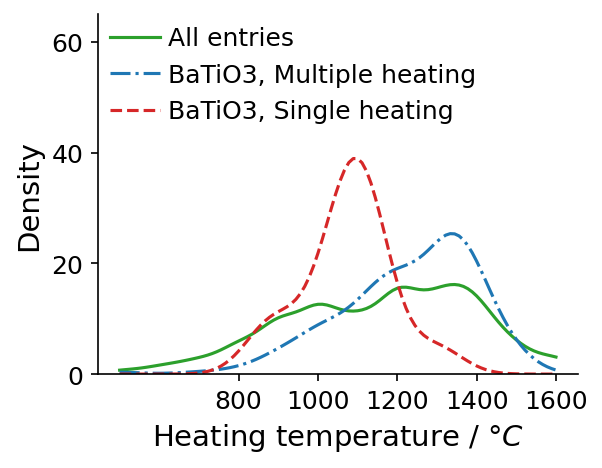

In [18]:
fig = plt.figure(figsize=(4, 3), dpi=150)

ax = fig.add_axes([0.15, 0.17, 0.8, 0.8])
from scipy.stats import gaussian_kde

BaCO3_TiO2 = carb_oxi.loc[carb_oxi.meta_precursors == ("BaCO3", "TiO2")]
# plt.hist(BaCO3_TiO2.query('feature_text_is_multi_heating == True').y_temperature, 
#          alpha=0.6, range=(500, 1600), bins=12, color='tab:blue')
# plt.hist(BaCO3_TiO2.query('feature_text_is_multi_heating == False').y_temperature, 
#          alpha=0.6, range=(500, 1600), bins=12, color='tab:red')

xrange = numpy.linspace(500, 1600, 100)

kernel = gaussian_kde(carb_oxi.y_temperature)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='-', color='tab:green', label=' All entries')

kernel = gaussian_kde(
    BaCO3_TiO2.query('feature_text_is_multi_heating == True').y_temperature
)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='-.', color='tab:blue', label=' BaTiO3, Multiple heating')

kernel = gaussian_kde(
    BaCO3_TiO2.query('feature_text_is_multi_heating == False').y_temperature
)
yrange = kernel(xrange)*10000
plt.plot(xrange, yrange, linestyle='--', color='tab:red', label=' BaTiO3, Single heating')

plt.xlabel('Heating temperature / $°C$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.gca().set_ylim([0, 65])
plt.gca().set_yticks(ticks=[0, 20, 40, 60])
plt.gca().set_yticklabels(labels=['0', '20', '40', '60'], fontsize=12)
plt.gca().set_xticks(ticks=[800, 1000, 1200, 1400, 1600])
plt.gca().set_xticklabels(labels=['800', '1000', '1200', '1400', '1600'], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

legend_format = {
    'fontsize': 12, 'fancybox': False, 'frameon': False, 
    'borderpad': 0., 'handletextpad': 0., 'loc': 'upper left'}
plt.legend(**legend_format)
# plt.tight_layout()
plt.savefig('figures/Fig.D2.BaCO3-TiO2.pdf')
plt.show()

## Applying the model to your own data

### Just using target composition

In [19]:
from pymatgen.core import Composition
just_element_features = [feat for feat in predictive_features_elemental if feat.startswith("feature_ele")]

def make_element_features(target_formula):
    comp = Composition(target_formula)
    return pandas.DataFrame([feat.split('_')[-1] in comp for feat in just_element_features], just_element_features).transpose()

# Quick test
make_element_features("BaTiO3")

,feature_ele_Li,feature_ele_Be,feature_ele_B,feature_ele_C,feature_ele_N,feature_ele_O,feature_ele_F,feature_ele_Na,feature_ele_Mg,feature_ele_Al,...,feature_ele_W,feature_ele_Re,feature_ele_Os,feature_ele_Ir,feature_ele_Hg,feature_ele_Tl,feature_ele_Pb,feature_ele_Bi,feature_ele_Th,feature_ele_U
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
from s4.ml.wls import do_linear_model

element_model = do_linear_model(
    data_frame=carb_oxi, 
    features=just_element_features, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)

In [21]:
target_formula = "LiTiO3"
target_features = make_element_features(target_formula)
print('With only elemental features', element_model.predict(target_features).values)

With only elemental features [925.87851566]


### Using precursors and target

In [22]:
from s4.ml.features import wp_mp, wp_mp_median

def make_melt_features(precursors):
    """
    Gets melting point features
    
    Args:
        precursors (list): list of precursors
    """
    precursors = tuple(sorted(precursors))
    melting_points = [wp_mp.get(Composition(x), wp_mp_median) for x in precursors]
    feature_dict = {
        'feature_exp_min_mp': min(melting_points),
        'feature_exp_max_mp': max(melting_points),
        'feature_exp_mean_mp': numpy.mean(melting_points),
        'feature_exp_div_mp': max(melting_points) - min(melting_points)}
    return pandas.DataFrame.from_dict([feature_dict], orient="columns")

In [23]:
make_melt_features(['Li2O2', 'TiO2'])

,feature_exp_min_mp,feature_exp_max_mp,feature_exp_mean_mp,feature_exp_div_mp
0,195.0,1843.0,1019.0,1648.0


In [24]:
melt_feature_labels = ['feature_exp_min_mp', 
        'feature_exp_max_mp',
        'feature_exp_mean_mp',
        'feature_exp_div_mp']

In [25]:
from s4.ml.wls import do_linear_model

element_melt_model = do_linear_model(
    data_frame=carb_oxi,
    features=just_element_features + melt_feature_labels, 
    y_name='y_temperature',
    do_wls=True, weights=1.0 / (1 + numpy.log(carb_oxi['meta_precursor_freq'].values)) ** 2,
)

In [46]:
def get_prediction(target, precursors):
    # Get elemental features
    elt_features = make_element_features(target)
    melt_features = make_melt_features(precursors)
    # Scale melt features down
    melt_features /= 1000
    all_features = pandas.concat([elt_features, melt_features], axis=1)
    # Make the prediction with model
    prediction = element_melt_model.predict(all_features)
    return prediction[0]

In [47]:
get_prediction("Li2TiO3", ["TiO2", "Li2CO3"])

929.4328562362259

In [36]:
li_ti_recipes = carb_oxi[numpy.logical_and(carb_oxi.feature_ele_Li, carb_oxi.feature_ele_Ti)]

In [44]:
li_ti_recipes[melt_feature_labels]

,,feature_exp_min_mp,feature_exp_max_mp,feature_exp_mean_mp,feature_exp_div_mp
meta_k,meta_i,,,,
39,0,0.723,1.843,1.283000,1.120
595,0,0.723,1.843,1.283000,1.120
88,0,0.723,1.974,1.513333,1.251
1118,0,0.723,1.843,1.283000,1.120
1123,0,0.723,1.843,1.283000,1.120
...,...,...,...,...,...
28456,0,0.723,1.843,1.283000,1.120
29035,0,0.723,1.843,1.283000,1.120
29533,0,0.723,1.843,1.283000,1.120


### Compare RMSE of with and without features

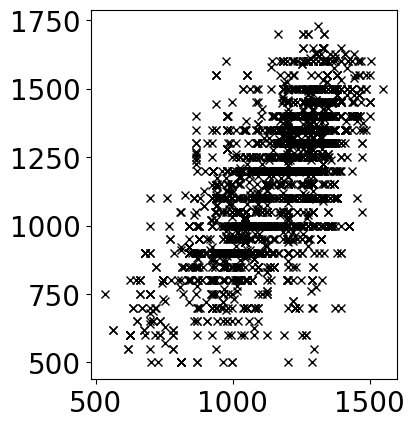

In [56]:
plt.plot(element_model.predict(carb_oxi), carb_oxi['y_temperature'], 'kx')

plt.gca().set_aspect('equal')
plt.show()

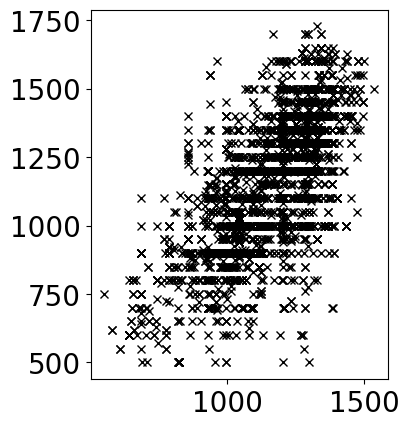

In [57]:
plt.plot(element_melt_model.predict(carb_oxi), carb_oxi['y_temperature'], 'kx')

plt.gca().set_aspect('equal')
plt.show()

In [68]:
from pprint import pprint
pprint({k.reduced_formula: v for k, v in wp_mp.items()})

{'Ag2CO3': 218.0,
 'Ag2F': 90.0,
 'Ag2MoO4': 483.0,
 'Ag2O': 300.0,
 'Ag2S': 836.0,
 'Ag2SO3': 100.0,
 'Ag2Se': 896.85,
 'Ag2SeO3': 530.0,
 'Ag2Te': 955.0,
 'Ag3AsO4': 830.0,
 'Ag3PO4': 849.0,
 'AgBF4': 71.5,
 'AgBr': 432.0,
 'AgBrO3': 309.0,
 'AgC': 120.0,
 'AgCN': 335.0,
 'AgCO2': 961.9,
 'AgCS(OF)3': 286.0,
 'AgCSN': 170.0,
 'AgCl': 455.0,
 'AgClO3': 230.0,
 'AgClO4': 486.0,
 'AgF': 435.0,
 'AgF2': 690.0,
 'AgI': 558.0,
 'AgN3': 250.0,
 'AgNO2': 140.0,
 'AgNO3': 209.7,
 'AgPF6': 102.0,
 'Al(BH4)3': -64.5,
 'Al(H3C)3': 15.0,
 'Al(H5C2)3': -46.0,
 'Al(HO)3': 300.0,
 'Al(NO3)3': 66.0,
 'Al2(MoO4)3': 705.0,
 'Al2(SO4)3': 770.0,
 'Al2O3': 2072.0,
 'Al2S3': 1100.0,
 'Al2Se3': 947.0,
 'Al4C3': 2200.0,
 'AlAs': 1740.0,
 'AlAsO4': 1000.0,
 'AlB12': 2070.0,
 'AlCl3': 192.6,
 'AlF3': 1290.0,
 'AlH10C4Cl': -50.0,
 'AlH15(C2O)3': 140.0,
 'AlH18C27(NO)3': 300.0,
 'AlH3': 150.0,
 'AlH4S2NO8': 93.5,
 'AlN': 2200.0,
 'AlP': 2530.0,
 'AlP3H18(C2O3)3': 215.0,
 'AlPO4': 1800.0,
 'AlSb': 1060.0,
 'AmCl3

/home/montoyjh/anaconda3/envs/synthesis/lib/python3.9/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
